In [1]:
import segmentation_models_pytorch as smp
import torch
from torch import nn

# Модель

In [2]:
def create_unet_with_10_channels():
    ''' 
    Архитектура нейросети.
    '''
    # Загружаем предобученную модель UNet с энкодером resnet34
    model = smp.Unet(
        encoder_name="resnet34",      # энкодер на основе resnet34
        encoder_weights="imagenet",   # используем предобученные веса
        in_channels=3,                # временно указываем 3 канала
        classes=1,
        activation = 'sigmoid'                   
    )
    
    # Модифицируем первый сверточный слой для работы с 10 каналами
    # Получаем текущий первый слой (3 канала)
    original_conv1 = model.encoder.conv1
    
    # Создаем новый слой с 10 каналами и тем же количеством выходов
    new_conv1 = nn.Conv2d(
        in_channels=10,
        out_channels=original_conv1.out_channels,
        kernel_size=original_conv1.kernel_size,
        stride=original_conv1.stride,
        padding=original_conv1.padding,
        bias=original_conv1.bias
    )
    
    # Копируем веса первых трех каналов из старого слоя в новый
    with torch.no_grad():
        new_conv1.weight[:, :3, :, :] = original_conv1.weight
        if new_conv1.weight.size(1) > 3:
            for i in range(3, 10):
                new_conv1.weight[:, i, :, :] = original_conv1.weight[:, i % 3, :, :]
    
    # Заменяем первый слой модели
    model.encoder.conv1 = new_conv1
    return model

# Создаем модель UNet с 10 входными каналами
model = create_unet_with_10_channels()
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

# Данные

In [3]:
from utils import tiff_to_tensor, plot_channels
import matplotlib.pyplot as plt

In [7]:
from torchvision.transforms.functional import crop
from pathlib import Path
import numpy as np
import scipy.ndimage as nd

In [4]:
def random_crop(img_tensor, crop_size=(640, 640)):
    """
    Делает случайный кроп изображения.
    
    Parameters:
    - img_tensor (torch.Tensor): Входной тензор изображения с форматом (channels, height, width).
    - crop_size (tuple): Размеры кропа (height, width).
    
    Returns:
    - torch.Tensor: Случайный кроп изображения.
    """
    c, h, w = img_tensor.shape
    crop_h, crop_w = crop_size

    # Убедимся, что размеры кропа не превышают исходные размеры
    assert crop_h <= h and crop_w <= w, "Размеры кропа превышают размеры изображения"

    # Генерируем случайные координаты верхнего левого угла кропа
    top = torch.randint(0, h - crop_h + 1, (1,)).item()
    left = torch.randint(0, w - crop_w + 1, (1,)).item()

    # Делаем кроп
    cropped_tensor = img_tensor[:, top:top + crop_h, left:left + crop_w]
    
    return cropped_tensor

In [5]:
def preprocess_mask(mask, dilation_iters=5, erosion_iters=5):
    """
    Выполняет морфологические операции над маской для выделения границ.
    
    Parameters:
    - mask: Тензор маски (1, h, w).
    - dilation_iters: Количество итераций для расширения.
    - erosion_iters: Количество итераций для сжатия.
    
    Returns:
    - torch.Tensor: Предобработанная маска с выделенными границами.
    """
    mask_np = mask[0].cpu().numpy().astype(bool)  # Преобразуем в numpy для операций
    # Выполняем расширение и сжатие
    dilated = nd.binary_dilation(mask_np, iterations=dilation_iters)
    eroded = nd.binary_erosion(mask_np, iterations=erosion_iters)
    
    # Вычисляем границу как разность
    border = dilated.astype(float) - eroded.astype(float)
    border = torch.from_numpy(border).unsqueeze(0)  # Преобразуем обратно в тензор (1, h, w)
    
    return border

In [6]:
def random_crop_within_mask(image, mask, crop_size=(640, 640)):
    """
    Вырезает случайный кроп по маске.
    
    Parameters:
    - image: Тензор изображения (c, h, w).
    - mask: Тензор маски (1, h, w).
    - crop_size=(640, 640): Размер кропа.
    
    Returns:
    - torch.Tensor: Вырезанное изображение.
    - torch.Tensor: Вырезанная маска.
    """
    _, h, w = image.shape
    crop_h, crop_w = crop_size
    
    border_mask = preprocess_mask(mask) # Убираем перевес в пользу сплошных водоёмов

    # Получаем индексы пикселей внутри маски
    mask_indices = torch.nonzero(border_mask[0] == 1, as_tuple=False)

    # Проверяем, что внутри маски есть достаточно места для кропа
    if len(mask_indices) == 0:
        raise ValueError("В маске нет пикселей со значением 1 для выбора центра кропа.")
    
    # Случайно выбираем центр из пикселей маски
    center_y, center_x = mask_indices[torch.randint(0, len(mask_indices), (1,))].squeeze()

    # Рассчитываем координаты начала и конца кропа
    start_y = max(0, center_y - crop_h // 2)
    start_x = max(0, center_x - crop_w // 2)
    end_y = min(h, start_y + crop_h)
    end_x = min(w, start_x + crop_w)

    # Корректируем начальные координаты, если они выходят за пределы
    start_y = max(0, end_y - crop_h)
    start_x = max(0, end_x - crop_w)

    # Выполняем кроп изображения и маски
    image_crop = image[:, start_y:end_y, start_x:end_x]
    mask_crop = mask[:, start_y:end_y, start_x:end_x]

    return image_crop, mask_crop

In [8]:
def get_crops(image, mask, size, intersection_rate=0.2):
    h, w = image.shape[1:3]
    step = int((1 - intersection_rate) * size)
    print(image.shape)
    crops = []
    masks = []
    
    for x1 in range(0, w, step):
        if x1 + size > w:
            x1 = w - size
        for y1 in range(0, h, step):
            if y1 + size > h:
                y1 = h - size
            i = image[...,y1:y1 + size, x1:x1 + size]
            m = mask[...,y1:y1 + size, x1:x1 + size]
            crops.append(i)
            masks.append(m)
    
    return crops, masks

In [9]:
import os
import rasterio
import numpy as np

In [17]:
# Параметры
size = 2048
intersection_rate = 0.1
image_dir = 'train/images'
mask_dir = 'train/masks'
output_dir = 'data'

# Создание директории для сохранения
os.makedirs(output_dir, exist_ok=True)

# Получение списка файлов изображений
image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.tif')]

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    # Чтение изображения
    with rasterio.open(img_path) as src:
        img_array = src.read()
    
    # Чтение маски
    with rasterio.open(mask_path) as src:
        mask_array = src.read()

    # Получение кропов
    c, m = get_crops(img_array, mask_array, size, intersection_rate)

    # Сохранение кропов в выходную директорию
    for i, (crop, mask) in enumerate(zip(c, m)):
        crop_output_path = os.path.join(output_dir, f'images/{img_file.split(".")[0]}_{i}.tif')
        mask_output_path = os.path.join(output_dir, f'masks/{mask_file.split(".")[0]}_{i}.tif')
        
        
        with rasterio.open(crop_output_path, 'w', driver='GTiff', height=crop.shape[1], width=crop.shape[2],
                           count=crop.shape[0], dtype=crop.dtype) as dst:
            dst.write(crop)
        with rasterio.open(mask_output_path, 'w', driver='GTiff', height=mask.shape[1], width=mask.shape[2],
                           count=mask.shape[0], dtype=mask.dtype) as dst:
            dst.write(mask)

print("Кропы и маски успешно сохранены в директорию 'data'.")




(10, 10134, 10680)


c:\Anaconda\envs\pip-torch\Lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


(10, 2648, 6744)
(10, 4389, 6708)
(10, 2336, 3230)
(10, 4971, 10632)
(10, 4971, 10632)
(10, 512, 512)
(10, 512, 512)
Кропы и маски успешно сохранены в директорию 'data'.


In [18]:
import gc
gc.collect()

0

# Dataloader

In [36]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, images, masks, crop_size=(640, 640), image_max=5000, mask_max=1, transform=None, n_crops=4):
        self.images = images
        self.masks = masks
        self.crop_size = crop_size
        self.image_max = image_max
        self.mask_max = mask_max
        self.transform = transform
        self.N = n_crops * len(self.images)

    def __len__(self):
        return self.N

    def __getitem__(self, idx):

        image_idx = idx % len(self.images)
        # Загружаем изображение и маску из файлов в формате TIFF
        image = tiff_to_tensor(self.images[image_idx], max=self.image_max)
        mask = tiff_to_tensor(self.masks[image_idx], max=self.mask_max)

        # Применяем функцию для случайного кропа внутри маски
        image_crop, mask_crop = random_crop_within_mask(image, mask, crop_size=self.crop_size)

        # Применяем дополнительные преобразования, если указаны
        if self.transform:
            augmented = self.transform(image=image_crop, mask=mask_crop)
            image_crop = augmented['image']
            mask_crop = augmented['mask']

        return image_crop.to('cuda'), mask_crop.to('cuda')

# Создаем DataLoader
def create_segmentation_dataloader(images, masks, crop_size=(640, 640), batch_size=8, shuffle=True, transform=None, n_crops=4):
    dataset = SegmentationDataset(images, masks, crop_size=crop_size, n_crops=n_crops)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [20]:
import os
import glob
import random

def get_dataset_splits(path_to_images='data\\images\\', path_to_masks='data\\masks\\', test_part=0.1):
    # Получаем список всех файлов изображений и масок
    image_files = glob.glob(os.path.join(path_to_images, '*.*'))  # Все файлы в папке images
    mask_files = glob.glob(os.path.join(path_to_masks, '*.*'))    # Все файлы в папке masks
    
    # Извлекаем названия файлов без расширений
    image_filenames = [os.path.splitext(os.path.basename(f))[0] for f in image_files]
    
    # Создаем соответствия масок
    mask_filenames = [path_to_masks + filename + '.tif' for filename in image_filenames]  # Предполагаем, что маски в формате .png

    # Случайное перемешивание изображений и масок
    combined = list(zip(image_files, mask_filenames))
    random.shuffle(combined)
    image_files[:], mask_filenames[:] = zip(*combined)

    # Определяем количество файлов для тестовой выборки
    total_files = len(image_files)
    i_train = int(total_files * (1 - test_part))

    # Разделяем на обучающую и тестовую выборки
    train = list(zip(image_files[:i_train], mask_filenames[:i_train]))
    test = list(zip(image_files[i_train:], mask_filenames[i_train:]))
    
    return train, test

In [21]:
def unzip_paths(l):
    image_paths, mask_paths = zip(*l)
    image_paths = list(image_paths)
    mask_paths = list(mask_paths)
    return image_paths, mask_paths
    

In [22]:
train, test = get_dataset_splits()

In [23]:
imgs_train, mask_train = unzip_paths(train)
imgs_val, mask_val = unzip_paths(test)

In [24]:
print(len(imgs_train), len(mask_train))

86 86


In [37]:
dataloader_train = create_segmentation_dataloader(imgs_train, mask_train, crop_size=(640, 640), batch_size=8)
dataloader_val = create_segmentation_dataloader(imgs_val, mask_val, crop_size=(640, 640), batch_size=4)

# Train

In [26]:
from tqdm import tqdm

In [27]:
class SegmentationTrainer:
    def __init__(self, model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda"):
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        
        # Списки для сохранения истории лоссов
        self.train_losses = []
        self.val_losses = []
        
        # Параметры для отслеживания лучшей модели
        self.best_val_loss = float("inf")
        self.best_model = None

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        for image_crop, mask_crop in tqdm(self.train_dataloader, desc="Training"):
            image_crop, mask_crop = image_crop.to(self.device), mask_crop.to(self.device)

            # Прогон через модель
            preds = self.model(image_crop)

            # Вычисление потерь
            loss = self.criterion(preds, mask_crop)
            total_loss += loss.item()

            # Обратное распространение и оптимизация
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        return total_loss / len(self.train_dataloader)

    def validate_epoch(self):
        self.model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for image_crop, mask_crop in tqdm(self.val_dataloader, desc="Validating"):
                image_crop, mask_crop = image_crop.to(self.device), mask_crop.to(self.device)

                # Прогон через модель
                preds = self.model(image_crop)

                # Вычисление потерь
                loss = self.criterion(preds, mask_crop)
                total_val_loss += loss.item()
        
        return total_val_loss / len(self.val_dataloader)

    def fit(self, num_epochs):
        for epoch in range(num_epochs):
            train_loss = self.train_epoch()
            val_loss = self.validate_epoch()
            
            # Сохраняем лоссы для текущей эпохи
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            # Сохраняем модель, если валидационный лосс улучшился
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_model = self.model.state_dict()  # Сохраняем состояние модели

            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    def plot_losses(self):
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

In [28]:
image_paths, mask_paths = zip(*train)
image_paths = list(image_paths)
mask_paths = list(mask_paths)
print("Image Paths:", len(image_paths))
print("Mask Paths: ", len(mask_paths))

Image Paths: 86
Mask Paths:  86


In [29]:
from segmentation_models_pytorch import utils as smp_utils

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

In [31]:
from model_unet import load_unet_model
m = load_unet_model()

c:\Jup\multispectral\model_unet.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load('best_model_dice.pth'))


In [33]:
IoUloss = smp_utils.losses.JaccardLoss()
DICEloss = smp_utils.losses.DiceLoss()

In [40]:
trainer = SegmentationTrainer(
    model=model,
    train_dataloader=dataloader_train,
    val_dataloader=dataloader_val,
    criterion= DICEloss,
    optimizer=optim.AdamW(model.parameters(), lr=0.01),
    device='cuda'
)


In [41]:
trainer.fit(num_epochs=10)

Validating: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


Epoch [1/10], Train Loss: 0.4745, Validation Loss: 0.6150


Validating: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


Epoch [2/10], Train Loss: 0.3094, Validation Loss: 0.4257


Validating: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Epoch [3/10], Train Loss: 0.2986, Validation Loss: 0.8180


Validating: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [4/10], Train Loss: 0.2814, Validation Loss: 0.4920


Validating: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


Epoch [5/10], Train Loss: 0.2441, Validation Loss: 0.3552


Validating: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


Epoch [6/10], Train Loss: 0.2333, Validation Loss: 0.2856


Validating: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


Epoch [7/10], Train Loss: 0.2433, Validation Loss: 0.6981


Validating: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


Epoch [8/10], Train Loss: 0.2919, Validation Loss: 0.8639


Validating: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Epoch [9/10], Train Loss: 0.2746, Validation Loss: 0.2646


Validating: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]

Epoch [10/10], Train Loss: 0.1897, Validation Loss: 0.3132


In [43]:
trainer.fit(num_epochs=5)

Training:   0%|          | 0/43 [00:00<?, ?it/s]c:\Anaconda\envs\pip-torch\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validating: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Epoch [1/5], Train Loss: 0.1960, Validation Loss: 0.3313


Validating: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


Epoch [2/5], Train Loss: 0.2200, Validation Loss: 0.3080


Validating: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Epoch [3/5], Train Loss: 0.2029, Validation Loss: 0.1783


Validating: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


Epoch [4/5], Train Loss: 0.1737, Validation Loss: 0.2694


Validating: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

Epoch [5/5], Train Loss: 0.1923, Validation Loss: 0.3020


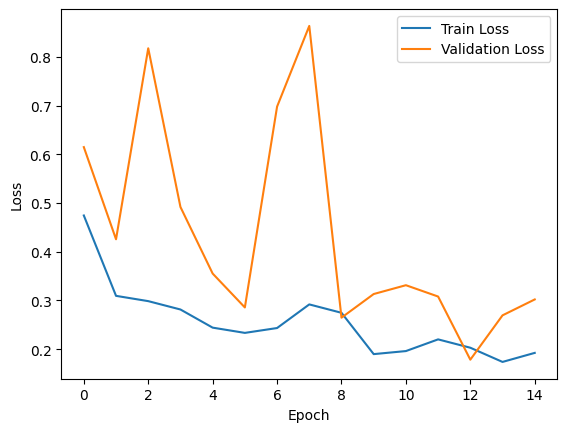

In [44]:
trainer.plot_losses()

In [40]:
def get_model_size(model):
    """Возвращает размер модели в мегабайтах (MB)."""
    param_size = sum(param.numel() * param.element_size() for param in model.parameters())
    buffer_size = sum(buf.numel() * buf.element_size() for buf in model.buffers())
    total_size = (param_size + buffer_size) / (1024 ** 2)  # переводим байты в мегабайты
    return total_size
get_model_size(trainer.model)

93.37395095825195

In [45]:

# Копируем модель из trainer в m
m = trainer.model

# Загружаем state_dict лучшей модели в m
m.load_state_dict(trainer.best_model)
torch.save(m.state_dict(), 'best_model_dice_0.pth')

In [18]:
images = ['train/images/2.tif','train/images/4.tif']
masks = ['train/masks/2.tif','train/masks/4.tif']

In [24]:
dataloader = create_segmentation_dataloader(images, masks, crop_size=(640, 640), batch_size=8, n_crops=64)
# Определите функцию потерь и оптимизатор
  # для многоклассовой сегментации; если бинарная, можно использовать nn.BCEWithLogitsLoss
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion1 = smp_utils.losses.DiceLoss()
criterion2 = smp_utils.losses.JaccardLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Обучающий цикл
num_epochs = 10  # укажите нужное количество эпох
model.train()
model.cuda()
for epoch in range(num_epochs):
    total_loss = 0
    for image_crop, mask_crop in dataloader:
        # Предсказание
        preds = model(image_crop)

        # Вычисление потерь
        loss1 = criterion1(preds, mask_crop)
        loss2 = criterion2(preds, mask_crop)
        loss = 0.6 * loss1 + 0.4 * loss2
        total_loss += loss.item()

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader)}")

cuda
Epoch [1/10], Loss: 0.8860511295497417
Epoch [2/10], Loss: 0.7871093712747097
Epoch [3/10], Loss: 0.6068238876760006
Epoch [4/10], Loss: 0.4539468493312597
Epoch [5/10], Loss: 0.3766907323151827
Epoch [6/10], Loss: 0.3315745033323765
Epoch [7/10], Loss: 0.3185655903071165
Epoch [8/10], Loss: 0.2900573778897524
Epoch [9/10], Loss: 0.26279278565198183
Epoch [10/10], Loss: 0.27494256664067507
